In [1]:
import argparse
from functools import partial
from glob import glob
from joblib import Parallel, delayed
import json
from nipype.caching import Memory
from nipype.interfaces import fsl
from nilearn import datasets, image
from nilearn.regions import RegionExtractor
from nilearn.decomposition import CanICA
import numpy as np
import os
from os import makedirs, path
import pandas as pd
import pickle
import re
import shutil
import sys

from utils.utils import (concat_and_smooth, create_neural_feature_mat, create_projections_df)
from utils.plot_utils import plot_2ndlevel_maps

180515-08:20:19,39 duecredit ERROR:
	 Failed to import duecredit due to No module named 'duecredit'


### Parse Arguments
These are not needed for the jupyter notebook, but are used after conversion to a script for production

- conversion command:
  - jupyter nbconvert --to script --execute 2ndlevel_analysis.ipynb

In [2]:
parser = argparse.ArgumentParser(description='fMRI Analysis Entrypoint Script.')
parser.add_argument('-derivatives_dir')
parser.add_argument('-working_dir', default=None)
parser.add_argument('--tasks', nargs="+")
parser.add_argument('--n_procs', default=4, type=int)
if '-derivatives_dir' in sys.argv or '-h' in sys.argv:
    args = parser.parse_args()
else:
    args = parser.parse_args([])
    args.derivatives_dir='/mnt/OAK/derivatives/'

In [3]:
derivatives_dir = args.derivatives_dir
fmriprep_dir = path.join(derivatives_dir, 'fmriprep', 'fmriprep')
first_level_dir = path.join(derivatives_dir, '1stlevel')
second_level_dir = path.join(derivatives_dir,'2ndlevel')
if args.working_dir is None:
    working_dir = path.join(derivatives_dir, '2ndlevel_workingdir')
else:
    working_dir = path.join(args.working_dir, '2ndlevel_workingdir')
makedirs(working_dir, exist_ok=True)
    
tasks = ['ANT', 'CCTHot', 'discountFix',
         'DPX', 'motorSelectiveStop',
         'stopSignal', 'stroop', 
         'surveyMedley', 'twoByTwo', 'WATT3']
if args.tasks:
    tasks = args.tasks


### Create group Mask

In [ ]:
def create_group_mask(mask_loc, fmriprep_dir, threshold=.8, verbose=True):
    if verbose:
        print('Creating Group mask...')
    makedirs(path.dirname(mask_loc), exist_ok=True)
    brainmasks = glob(path.join(fmriprep_dir,'sub-s???',
                               '*','func','*MNI152NLin2009cAsym_brainmask*'))
    mean_mask = image.mean_img(brainmasks)
    group_mask = image.math_img("a>=0.8", a=mean_mask)
    group_mask.to_filename(mask_loc)
    if verbose:
        print('Finished creating group mask')

# create mask over all tasks
# create 95% brain mask
mask_loc = path.join(second_level_dir, 'group_mask.nii.gz')
if path.exists(mask_loc) == False:
    create_group_mask(mask_loc, fmriprep_dir, .8)

In [ ]:
"""
# save subject names in order on 1st iteration
if i==0:
    subj_ids = [re.search('s[0-9][0-9][0-9]', file).group(0) 
                    for file in map_files]
    # see if these maps have been run before, and, if so, skip
    try:
        previous_ids = json.load(open(join(data_dir,
                                           task,
                                           'subj_ids.json'), 'r'))
        if previous_ids == subj_ids:
            print('No new subjects added since last ran, skipping...')
            break
        else:
            json.dump(subj_ids, open(join(task_dir, 'subj_ids.json'),'w'))
    except FileNotFoundError:
        json.dump(subj_ids, open(join(task_dir, 'subj_ids.json'),'w'))
"""

In [ ]:
# ********************************************************
# Create group maps
# ********************************************************
def get_contrast_tmap(task, regress_rt=True, smoothness=4.4,
             second_level_dir=second_level_dir,
             first_level_dir=first_level_dir,
             mask_loc=mask_loc,
             verbose=True):
    model = 'model-rt' if regress_rt == True else 'model-nort'
    task_dir = path.join(second_level_dir, task, model, 'wf-contrast')
    makedirs(task_dir, exist_ok=True)
    # get contrasts
    subjectinfo_paths = glob(path.join(first_level_dir, '*', task, model, 
                                       'wf-contrast','subjectinfo.pkl'))
    try:
        contrasts = pickle.load(open(subjectinfo_paths[0], 'rb')).contrasts
        contrast_names = [i[0] for i in contrasts]
    except IndexError:
        print('No subjectinfo found for %s_%s' % (task, model))
        return

    if verbose: print('Creating %s group map' % task)
    for i, contrast_name in enumerate(contrast_names):
        name = contrast_name
        if verbose: print('    Contrast: %s' % contrast_name)
        # load, smooth, and concatenate contrasts
        map_files = sorted(
            glob( path.join(first_level_dir, '*', task, model,
                            '*contrast', '*cope%s.nii.gz' % str(i + 1))))
        # if there are map files, create group map
        if len(map_files) > 1:
            smooth_copes = concat_and_smooth(map_files, smoothness=smoothness)
            copes_concat = image.concat_imgs(
                smooth_copes.values(), auto_resample=True)
            copes_loc = path.join(task_dir, "%s_copes.nii.gz" % name)
            copes_concat.to_filename(copes_loc)

            # perform permutation test to assess significance
            mem = Memory(base_dir=working_dir)
            randomise = mem.cache(fsl.Randomise)
            randomise_results = randomise(
                in_file=copes_loc,
                mask=mask_loc,
                one_sample_group_mean=True,
                tfce=True,  # look at paper
                vox_p_values=True,
                num_perm=100)
            # save results
            tfile_loc = path.join(task_dir, "%s_raw_tfile.nii" % name)
            tfile_corrected_loc = path.join(task_dir,
                                       "%s_corrected_tfile.nii" % name)
            raw_tfile = randomise_results.outputs.tstat_files[0]
            corrected_tfile = randomise_results.outputs.t_corrected_p_files[0]
            shutil.move(raw_tfile, tfile_loc)
            shutil.move(corrected_tfile, tfile_corrected_loc)

In [ ]:
# create group maps
for regress_rt in [True, False]:
    # create partial function to pass to parallel
    contrast_tmap_parallel = partial(get_contrast_tmap, regress_rt=regress_rt, smoothness=4.4, 
                            second_level_dir=second_level_dir,
                            first_level_dir=first_level_dir,
                            mask_loc=mask_loc,
                            verbose=False)
    Parallel(n_jobs=args.n_procs)(delayed(contrast_tmap_parallel)(task) for task in tasks)

In [ ]:
#plot_1stlevel_maps('/mnt/OAK/derivatives/1stlevel/s061/stroop/model-rt/wf-contrast/')

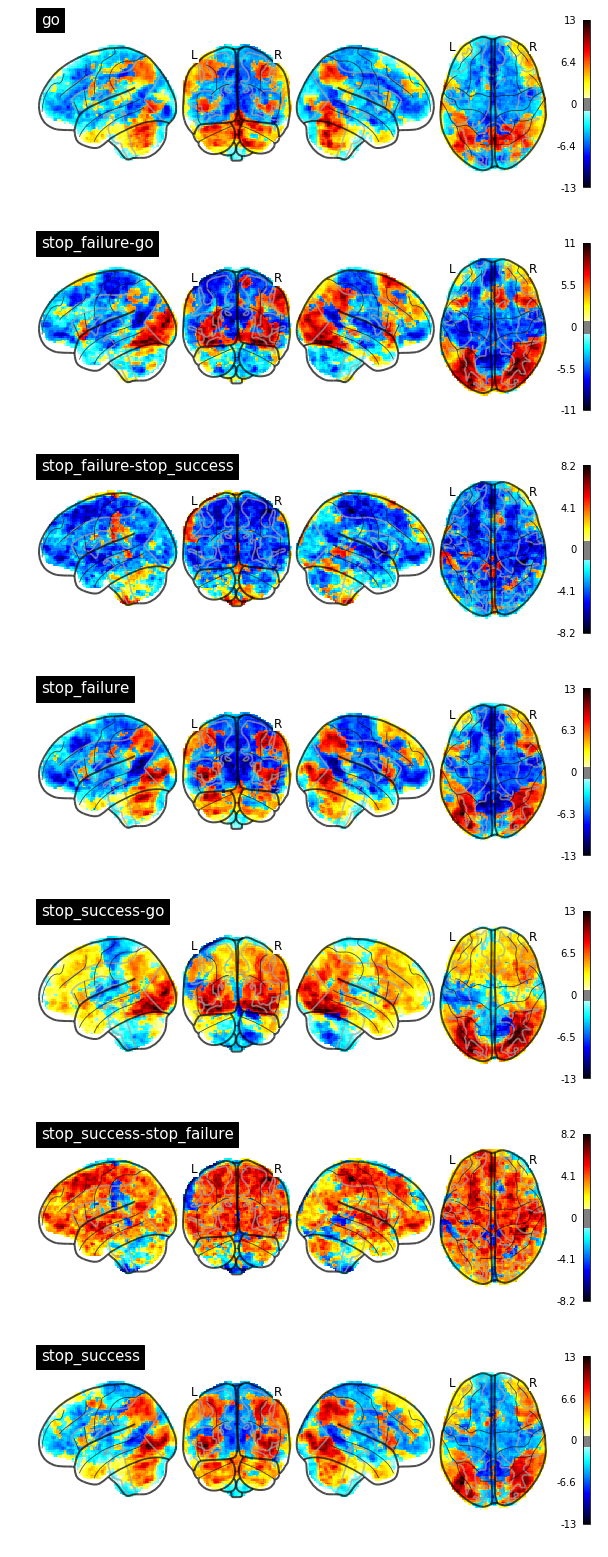

In [55]:
% matplotlib inline
task='stopSignal'
model='model-rt'
plot_2ndlevel_maps(path.join(second_level_dir,task,model,'wf-contrast'), lookup='*raw*')
#plot_2ndlevel_maps(path.join(second_level_dir,task,model,'wf-contrast'), lookup='*corrected*', threshold=.95)

In [ ]:
"""
# ********************************************************
# Set up parcellation
# ********************************************************

#******************* Estimate parcellation from data ***********************
print('Creating ICA based parcellation')

# get map files of interest (explicit contrasts)
map_files = []
for task in tasks: 
    contrast_path = sorted(glob(join(data_dir,'*%s/contrasts.pkl' % task)))
    if len(contrast_path)>0:
        contrast_path = contrast_path[0]
    else:
        continue # move to next iteration if no contrast files found
    contrast_names = get_contrast_names(contrast_path)
    for i, name in enumerate(contrast_names):
        # only get explicit contrasts (i.e. not vs. rest)
        if '-' in name or 'network' in name:
            map_files += sorted(glob(join(data_dir,
                                   '*%s/zstat%s.nii.gz' % (task, i+1))))

# group map files by subject
subject_ids = np.unique([f.split(os.sep)[-2].split('_')[0] for f in map_files])
subject_map_files = []
for s in subject_ids:
    subject_map_files.append(image.concat_imgs([f for f in map_files if s in f]))

    
n_components_list = [20,50,70]
for n_comps in n_components_list:
    ##  get components
    canica = CanICA(mask = group_mask, n_components=n_comps, 
                    smoothing_fwhm=4.4, memory=join(working_dir, "nilearn_cache"), 
                    memory_level=2, threshold=3., 
                    verbose=10, random_state=0) # multi-level components modeling across subjects
    
    canica.fit(map_files)
    masker = canica.masker_
    components_img = masker.inverse_transform(canica.components_)
    components_img.to_filename(join(output_dir, 
                                    'canica%s_explicit_contrasts.nii.gz' 
                                    % n_comps))
    

##************* Get parcellation from established atlas ************
## get smith parcellation
smith_networks = datasets.fetch_atlas_smith_2009()['rsn70']

# ********************************************************
# Helper functions
# ********************************************************



# ********************************************************
# Reduce dimensionality of contrasts
# ********************************************************
def split_index(projections_df):
    subj = [f.split('_')[0] for f in projections_df.index]
    contrast = ['_'.join(f.split('_')[1:]) for f in projections_df.index]
    projections_df.insert(0, 'subj', subj)
    projections_df.insert(1, 'contrast', contrast)
    
    
parcellation_files = [('smith70', smith_networks),
                      ('canica20', 
                       join(output_dir, 'canica20_explicit_contrasts.nii.gz')),
                      ('canica50', 
                       join(output_dir, 'canica50_explicit_contrasts.nii.gz')),
                       ('canica70', 
                       join(output_dir, 'canica70_explicit_contrasts.nii.gz'))
                       ]

for parcellation_name, parcellation_file in parcellation_files:
    projection_filey = join(output_dir, '%s_projection.json' % parcellation_name)
    mask_file = join(output_dir, 'group_mask.nii.gz')
    projections_df = create_projections_df(parcellation_file, mask_file, 
                                           data_dir, tasks, projection_filey)
    
    # create a subject x neural feature vector where each column is a component
    # for one contrast
    neural_feature_mat = create_neural_feature_mat(projections_df,
                                                   filename=join(output_dir, 
                                                        '%s_neural_features.json'  
                                                        % parcellation_name))
"""